In [1]:
import os
import sys
import pickle

import git

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir

if not repo_path in sys.path:
    sys.path.append(repo_path)

if not os.getcwd() == repo_path:
    os.chdir(repo_path)

In [2]:
print(os.listdir())

['.gitignore', '.git', 'src', 'notes', 'cluster_runs', 'code', 'report']


In [3]:
def get_pickle_paths(dir):
    # collect pickle paths
    paths = []
    for fp in os.listdir(dir):
        if fp.endswith(".pickle"):
            print("path added: " + dir + fp)
            paths.append(dir + fp)
    return paths

# define dir
run_date = "231108"
run_name = ""

#hom_path = "cluster_runs/" + run_date + "/" + run_name + "/"
#inhom_path = "cluster_runs/" + run_date + run_name + "inhom/"
path = "cluster_runs/" + run_date + "/" + run_name

# get paths
pickles_paths = get_pickle_paths(path)

with open(pickles_paths[0], "rb") as f:
    results = pickle.load(f)

path added: cluster_runs/231108/136054110-timing.pickle


# First step
We do a loglog plot on the timing data, and show that the 

In [4]:
keys = np.array([])

system_sizes = np.array([])
# get keys
for N, result in results.run_results.items(): #system size
    system_sizes = np.append(system_sizes, N)
    keys = result.sim_results.keys()

keys = list(keys)

print("System sizes N: ", system_sizes)
print("Solver ids: ", keys)

System sizes N:  [ 50. 100. 150. 200. 300. 400. 500.]
Solver ids:  ['NBM', 'CBM-Nc1', 'CBM-Nc2', 'CBM-Nc3', 'CBM-Nc5', 'CBM-Nc7', 'CBM-Nc10', 'CBM-Nc12', 'CBM-Nc15', 'CBM-Nc17', 'CBM-Nc20', 'CBM-Nc24']


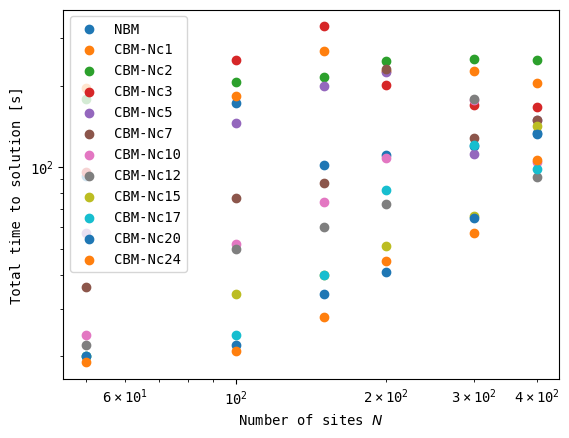

In [35]:
fig1, ax1 = plt.subplots()

# Constructing the data
mean_data = {}

key_to_num_iterations = {}

key_to_total_time = {}

for key in keys:
    d_log = np.empty([0, 2])
    d = np.empty([0, 2])
    d_num_iterations = np.empty([0, 2])

    for N, result in results.run_results.items(): #system size
        d_log = np.vstack(
            [d_log, [N, np.mean(result.sim_results[key].total_time)]], # append a point
        )

        d = np.vstack(
            [d, [N, np.mean(result.sim_results[key].time_per_iteration)]]
        )

        d_num_iterations = np.vstack(
            [d_num_iterations, [N, result.sim_results[key].get_num_of_iterations()]]
        )



        # print(key, np.mean(result.sim_results[key].get_delta()))
    mean_data[key] = d_log
    key_to_total_time[key] = d
    key_to_num_iterations[key] = d_num_iterations

    ax1.scatter(d_num_iterations[:-1,0], d_num_iterations[:-1,1], label=key)
    # ax1.scatter(system_sizes, d, label=key)
#ax1.boxplot(d)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xlabel(r"Number of sites $N$")
ax1.set_ylabel("Total time to solution [s]")



ax1.legend()

plt.show()    
    

## Fitting the data
Using the data in log, we can perform a linear regression on the points for each solver's result. 

In [24]:
from scipy import stats


def linfunc(x, slope, intercept):
  return slope * x + intercept

def exp_func(x, a, b):
  return a * np.power(x, b)



NBM       0.08
CBM-Nc1   0.07
CBM-Nc2   0.1
CBM-Nc3   0.15
CBM-Nc5   0.35
CBM-Nc7   0.57
CBM-Nc10  0.7
CBM-Nc12  0.79
CBM-Nc15  0.83
CBM-Nc17  0.84
CBM-Nc20  0.87
CBM-Nc24  0.74


/tmp/ipykernel_627814/3364560289.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


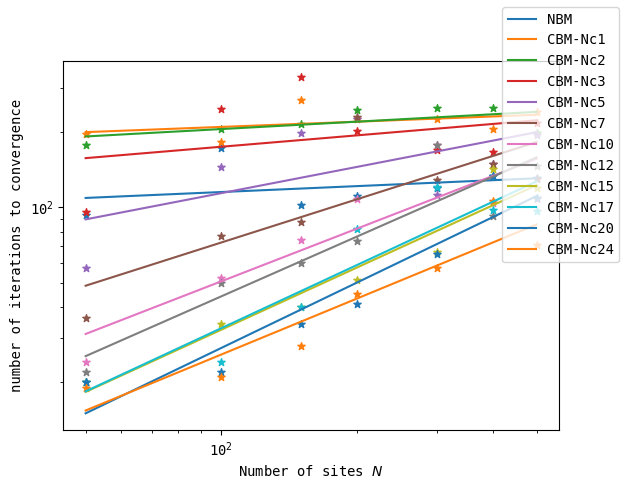

In [38]:
fig2, ax2 = plt.subplots()
# params
show_points = True

slopes = dict()

for key in keys:
  # data = key_to_total_time[key]
  data = key_to_num_iterations[key]
  data = data[:]

  slopes[key], intercept, r, p, std_err = stats.linregress(
    np.log(data[:,0]), 
    np.log(data[:,1],
           )
  )

  xmin = np.min(data[:,0])
  xmax = np.max(data[:,0])
  x_points = np.linspace(xmin, xmax)
  
  ax2.plot(x_points, exp_func(
    x=x_points, 
    a=np.exp(intercept), 
    b=slopes[key]
  ),
    label = key,
    #linestyle="dashed"
  )
  
  if show_points:
    ax2.scatter(
      data[:,0], 
      data[:,1], 
      marker="*",
      s=30,
    )


plt.rcParams["font.family"] = "monospace"

ax2.set_yscale('log')
ax2.set_xscale('log')
# ax1.grid()

ax2.set_xlabel(r"Number of sites $N$")
ax2.set_ylabel(r"number of iterations to convergence")

size = 10
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)

for key, slope in slopes.items():
  print("{0:10}{1}".format(key, round(slope, 2)))

fig2.legend()
fig2.show()



In [37]:
fig2.savefig(repo_path + "/report/figures/num_iterations.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
